# Compositional transfer learning

This is a notebook demonstrating compositional transfer learning with Bayesian inference over kernel grammar fragments. Kernels produced by these grammar fragments can used to create Gaussian processes.

Suppose we have a hypothesis space $\mathcal{H}_{k}$ of different kernels, produced by a kernel grammar $G$. We seek to model an underlying function with the use of these kernels. Beliefs about the underlying structure of the function can be encoded in the prior over $\mathcal{H}_{k}$. However, such  beliefs can be encoded more abstractly in probabilities over certain fragments of the grammar which produced $\mathcal{H}_{k}$ to begin with. For instance, say that the grammar $G$ can produce any algebraic combination of linear, cosine and radial basis kernels, then a fragment of $G$ could be a grammar using only a subset of the rules and components of $G$.

Formally, a standard kernel grammar $G$ (for instance as per Duvenaud's ABCD) has a set of basis kernels $\mathcal{B}$, and a set of rules $R$ by which it can produce and expand any kernel expression, denoted by $\mathcal{S}$. These rules may be the following:


$$\mathcal{S} \rightarrow \mathcal{S} + \mathcal{B}$$
$$\mathcal{S}\rightarrow \mathcal{S} \times \mathcal{B}$$
$$\mathcal{B}\rightarrow\mathcal{B'}$$
$$\mathcal{B} \rightarrow \varepsilon$$

Such a grammar will pick a starting kernel at random from $\mathcal{B}$ and generate composite kernels probabilistically from there (by a random walk through the grammar). Fragments of $G$ on the other hand may have quite specific starting kernels (a root), and only a subset of $\mathcal{B}$ with which it can generate kernel expressions. For instance, we can imagine a grammar fragment whose root is the additive kernel $k_{lin} + k_{cos}$, and whose set of basis kernels $\mathcal{B}$ only includes the linear and cosine kernel. This grammar fragment would start off at the root, generating (composite) kernel expressions for instance by performing random walks.

Importantly, we can define the probability of any kernel $k$ being generated by a fragment of $G$: If a fragment $F$ can generate a kernel $k$, then let the probability of that kernel, given the fragment be proportional to how many rules from $R$ one need to apply to produce that kernel, starting from the root. Formally, let $p(k\mid F) \propto \mathcal{P}^{S}$, where $\mathcal{P}$ is a complexity penalty term, and $S$ is the number of rules.

With this in place, we can generate a hypothesis space of kernels simply by sampling from different kernel grammar fragments. If we assume a prior distribution over the fragments, we can define the prior distribution of the resulting kernel hypothesis space as being proportional to the likelihood of that kernel and the fragment that produced it $p(h) \propto p(k_{ij}, F_{i})$. Now we are free to perform Bayesian inference, not only over kernels in $\mathcal{H}$, but also the fragments $F$ from which they are sampled: $$p(F, k\mid \mathcal{D}) \propto p(\mathcal{D}\mid k)p(k\mid F)p(F)$$ 


### Hierarchical Bayesian inference with kernel grammar fragments

One interesting feature of this hierarchical Bayesian approach is that posterior beliefs about kernel grammar fragments, encoding more abstract beliefs about underlying functional structure, will be updated compositionally. This is demonstrated bellow:

In [1]:
#imports:
import numpy as np
from matplotlib import pyplot as plt
import random
from GP_inference import *
from helper_functions import *
import NeuralDictionary
import gpytorch
import torch
from kernel_priors import *
import KernelFamily
import latent_functions

# format floats in numpy
float_formatter = "{:.5f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

First we define some base kernels from which we will define the kernel grammars, using these base kernels to generate more complex, compositional kernel expressions

In [2]:
# base kernels
lin = gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel(variance_prior=linear_variance_prior), outputscale_prior=linear_outputscale_prior)
cos = gpytorch.kernels.ScaleKernel(gpytorch.kernels.CosineKernel(period_length_prior=per_period_len_prior), outputscale_prior=per_outputscale_prior)
rbf = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=rbf_lengthscale_prior), outputscale_prior=rbf_outputscale_prior)

# create different possible roots for the kernel grammar fragments
lin_rbf_add = lin + rbf
lin_rbf_mul = lin * rbf
lin_cos_add = lin + cos
lin_cos_mul = lin * cos
rbf_cos_add = rbf + cos
rbf_cos_mul = rbf * cos
cos_rbf_add = cos + rbf
cos_rbf_mul = cos * rbf
lin_cos_rbf_add = rbf + cos + lin

Now we can define fragment grammars, covering different (and sometimes overlapping) parts of the kernel space. For this demonstration, we stick to one fragment covering linear kernels, one for cosine kernels, and one for their composition. We also give these fragments quite flat priors, based on how many base kernels the fragments have (the idea is to penalize more complex grammar fragments).

In [3]:
# define kernel grammar fragments with KernelFamily class:
complexity_penalty = 0.5

lin_root = [lin]
lin_core = lin_root
lin_familiy = KernelFamily.KernelFamily(lin_core, lin_root, complexity_penalty, only_additive = True)


cos_root = [cos]
cos_core = cos_root
cos_familiy = KernelFamily.KernelFamily(cos_core, cos_root, complexity_penalty, only_additive = True)

lin_cos_root = [lin_cos_add]
lin_cos_core = [lin, cos]
lin_cos_family = KernelFamily.KernelFamily(lin_cos_core, lin_cos_root, complexity_penalty, only_additive = True)

kernel_families = [lin_familiy, cos_familiy, lin_cos_family]
# give priors based on complexity
family_complexity = np.array([len(fam.basis_kernels) for fam in kernel_families])
family_priors = getPenalizedUniform(family_complexity).reshape(-1, 1)

Now we can sample kernels from this hypothesis space of kernel grammars. We'll sample 2 unique kernels from each grammar, and we make sure that one of these kernels is the grammar's root kernel.

In [4]:
core_kernels, probabilities = sample_from_grammar_fragments(kernel_families, family_priors, unique = True, includes_root = True, num_draws = 2
                                                           )
print(probabilities)


[0.28935 0.07234 0.28935 0.14467 0.20390 0.00040]


Now we can see how posterior beliefs about fragments are updated from posterior beliefs about kernels. Suppose we have a posterior distribution for kernels. To get the posterior for fragments we first need to compute the probability of each fragment given the kernels in $\mathcal{H}$, and then scale by the probability of each kernel given $\mathcal{D}$. The former is done with $\texttt{compute_family_posterior}$ function, the latter with the $\texttt{compute_joint_posterior}$ function

In [5]:
posterior = np.array([0.5, 0.3, 0.05, 0.05, 0.05, 0.05])


family_posterior = compute_family_posterior(kernel_families, family_priors, core_kernels)
joint_posterior, family_posterior = compute_joint_posterior(posterior, family_posterior)
print(family_posterior)


[0.60109 0.06326 0.33564]


Naturally, we see a high posterior for the linear fragment. Interestingly, the posterior of the $\texttt{LinearCosine}$ fragment is much higher than that of the $\texttt{Cosine}$ fragment despite their core kernels having the same posterior probability, since it has a decent likelihood of generating the linear kernels. This compositional inference can be seen more strongly for more uniform posteriors:

In [6]:
posterior = np.array([0.2, 0.1, 0.3, 0.1, 0.2, 0.1])


family_posterior = compute_family_posterior(kernel_families, family_priors, core_kernels)
joint_posterior, family_posterior = compute_joint_posterior(posterior, family_posterior)
print(family_posterior)

[0.22870 0.29657 0.47473]


Despite the cosine kernels having the highest posterior, the _fragment_ with the highest posterior is the $\texttt{LinearCosine}$, since it can explain portions of the variance explained by all kernels in $\mathcal{H}$. Furthermore, the posterior isn't dominated by $\texttt{LinearCosine}$ either, as the $\texttt{Linear}$ and $\texttt{Cosine}$ fragments are more likely to produce the simpler kernels in $\mathcal{H}$. Thus, the hierarchical Bayesian inference avoids overfitting as well.

Now we can use this updated posterior to produce a new hypothesis space of kernels:

In [7]:
family_priors = family_posterior.reshape(-1, 1)
core_kernels, probabilities = sample_from_grammar_fragments(kernel_families, family_priors, unique = True, includes_root = True, num_draws = 2
                                                           )
print(probabilities)

[0.21705 0.00170 0.28146 0.03518 0.45054 0.01408]


### Compositional knowledge transfer from episodic memory

We can extend this to cases where one may want to transfer knowledge of functional forms learned in one context $c$, to a similar, novel context $c'$. Suppose you have learnt posterior distributions of a set of kernels $\mathcal{H}$ in a set of contexts $\mathbf{c} = c_{1}, ... c_{n}$, each with features $\mathbf{X}$. Upon encountering a new context  $c'$ with features  $\mathbf{X'}$, what should your prior beliefs over the  $h\in\mathcal{H}$ be? This prior could be described as the posterior probability of kernels, given past data, and the similarity of the situation from which the data was sampled: $$\mathbf{p}(h\mid\mathcal D, c', \mathbf{c}) \propto \sum_{i}^{n}\mathbf{p}_{i}(\mathcal{D}\mid h)\mathbf{p}_{i}(h)k(c_{i}, c')$$

Here, $\mathbf{p}$ is a vector of probabilities (indexed by a context), $k$ is the similarity measure (for instance cosine similarity), $c'$ is the current context and $\mathbf{c}$ are remembered contexts. One way to get informed priors is to take the average over posteriors from remembered contexts, weighted by how similar they are to the current context: $$\mathbf{p}(h)_{new} = \sum_{i}^{n} \mathbf{p}_{i}(h\mid\mathcal{D})\left(\dfrac{k(c_{i}, c')}{\sum_{j}^{m}k(c_{j}, c')}\right)$$

That is, for each context stored in memory, we have a vector of probabilities $\mathbf{p}$. We then weigh $\mathbf{p}$ by the normalized similarity. The sum of all $\mathbf{p}_{i}$ yields the informed prior for context $c'$. Importantly, one would want to use this informed prior based on one's beliefs that those past experiences are transferrable to the novel context. For instance, one could have a default, flat prior $\mathbf{p}(h)_{old}$ and update this proportional to a term $\alpha$ which specifies the degree to which one generalizes: $\mathbf{p} = (1 - \alpha)\mathbf{p}_{old} + \alpha\mathbf{p}_{new}$. The generalization rate $\alpha$ may be a free parameter which one could fit to data, but could also be defined based on one's certainty that similar remembered contexts characterize the present context.

Furthermore, these informed priors can be used to update prior beliefs about grammar fragments, shown above. Now we can take a look at how this works in a contextual function learning task with GPs. We start by defining grammar fragments and by sampling kernels from them. For simplicity, we use the same as above. We then create a $\texttt{NeuralDictionary}$ object to store and bind posteriors to contexts.

In [8]:
# define (flat) kernel families priors and generate a hypothesis space of kernels sampled from families
family_complexity = np.array([len(fam.basis_kernels) for fam in kernel_families])
family_priors = getPenalizedUniform(family_complexity).reshape(-1, 1)
core_kernels, kernel_priors = sample_from_grammar_fragments(kernel_families, family_priors, unique = True, includes_root = True, num_draws = 2)

parameters = get_kernel_params(core_kernels)
indices = np.array([i for i in range(len(core_kernels))])
#Create neural dictionary containing episodic memories:
neuro_dict = NeuralDictionary.NeuralDictionary(indices, generalization_rate=1, kernel_parameters=parameters)

print(kernel_priors)


[0.28226 0.14113 0.28226 0.07057 0.19891 0.02486]


Now we feed it data from a linear and periodic latent function, as well as contextual features, respectively. The aim is to learn those functions to see the resulting compositional bias for contextually similar encounters, or encounters whose features are composed of previously experienced features:

Step: 49/50, loss: 0.3939041197299957
Step: 49/50, loss: 0.3926675617694855
Step: 49/50, loss: 0.3928295969963074
Step: 49/50, loss: 0.42190617322921753
Step: 49/50, loss: 0.421109676361084
Step: 49/50, loss: 0.4219600558280945
Step: 49/50, loss: 38.940208435058594
Step: 49/50, loss: 45.474037170410156
Step: 49/50, loss: 32.21388244628906
Step: 49/50, loss: 53.02594757080078
Step: 49/50, loss: 32.129215240478516
Step: 49/50, loss: 34.187442779541016
Step: 49/50, loss: 0.8476325869560242
Step: 49/50, loss: 0.8433755040168762
Step: 49/50, loss: 0.7856191396713257
Step: 49/50, loss: 0.8147444725036621
Step: 49/50, loss: 0.8141929507255554
Step: 49/50, loss: 0.8146803975105286
[0.49529 0.24049 0.00000 0.00000 0.23561 0.02860]


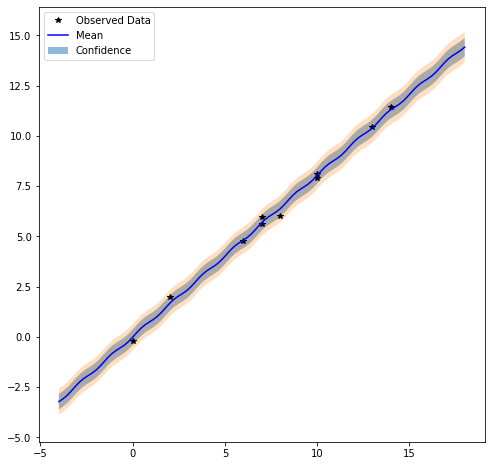

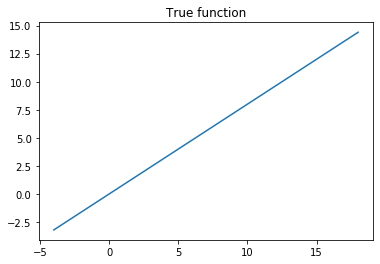

In [9]:
# linear
# define contextual features.
context, features = "10", np.array([1, 0])
# train x and y, here I use random samples of x, use torch.linspace(0, 15, 10) to get evenly distributed x sample
#torch.linspace(0, 10, 11)
train_x1 = torch.tensor([random.randint(0, 15) for i in range(10)]).float()
train_y1 = latent_functions.linear(train_x1, sd = 0.2)

# testing points and true function
test_x = create_test_x((train_x1.min().item() - 4, train_x1.max().item()+ 4), 100)
true_y = latent_functions.linear(test_x, sd = 0.)

# begin training: feed train and test data to function, returns kernel posterior, predictive distribution, predictions and confidence
posterior, predictive_dist, y_hat, confidence = bayesianGPInference(train_x1, train_y1,
                                                                    core_kernels, kernel_priors, test_x, display_result=True)
plt.plot(test_x.numpy(), true_y.numpy())
plt.title("True function")
plt.show()
# append results to dictionary/episodic memory
neuro_dict.append(context, features, posterior, train_x1, train_y1)

After optimizing marginal likelihood (3 restarts for each kernel) and performing bayesian inference over kernels (hence the slight nonlinearity in the posterior predictive), we get a final predictive distribution shown above. The posteriors, also printed above, are stored in memory. Now we do the same for a periodic function:

Step: 49/50, loss: 164.68087768554688
Step: 49/50, loss: 164.64967346191406
Step: 49/50, loss: 164.65402221679688
Step: 49/50, loss: 164.6827850341797
Step: 49/50, loss: 164.68505859375
Step: 49/50, loss: 164.7187042236328
Step: 49/50, loss: 0.916599452495575
Step: 49/50, loss: 0.9658952951431274
Step: 49/50, loss: 0.9214932322502136
Step: 49/50, loss: 0.7226976752281189
Step: 49/50, loss: 0.7041707634925842
Step: 49/50, loss: 0.7212163209915161
Step: 49/50, loss: 1.1786320209503174
Step: 49/50, loss: 1.1935285329818726
Step: 49/50, loss: 1.1804198026657104
Step: 49/50, loss: 1.2090600728988647
Step: 49/50, loss: 1.2102606296539307
Step: 49/50, loss: 1.2086341381072998
[0.00000 0.00000 0.52051 0.15973 0.28517 0.03458]


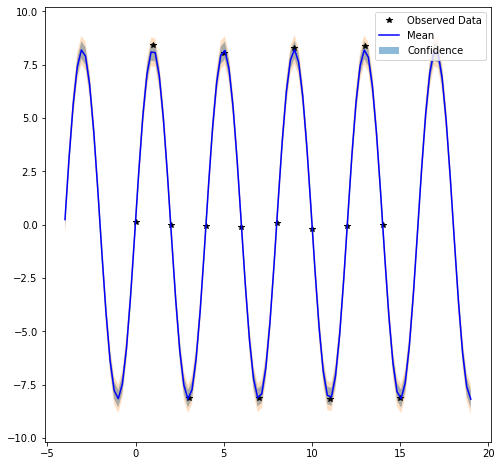

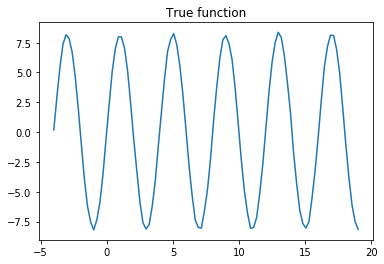

In [21]:
# periodic
# define contextual features.
context, features = "01", np.array([0, 1])

train_x2 = torch.linspace(0, 15, 16)
#train_x2 = torch.tensor([random.randint(0, 15) for i in range(10)]).float()
train_y2 = latent_functions.periodic(train_x2, periodicity=0.5)

# testing points:
test_x = create_test_x((train_x2.min().item() - 4, train_x2.max().item()+ 4), 100)
true_y = latent_functions.periodic(test_x, periodicity=0.5)

posterior, predictive_dist, y_hat, confidence = bayesianGPInference(train_x2, train_y2,
                                                                   core_kernels, kernel_priors, test_x, display_result=True)

# plot true
plt.plot(test_x.numpy(), true_y.numpy())
plt.title("True function")
plt.show()

# append results to dictionary/episodic memory
neuro_dict.append(context, features, posterior, train_x2, train_y2)

Now we can test the procedure's affinity for compositional learning: We have stored posterior and contexts in memory, so we can invoke these if we encounter a context in which we want to generalize from memory, for instance in contexts whose features are compositions of past experienced features:

In [22]:
context, features = "11", np.array([1, 1]) # context is composed of past contexts

# create the transfer prior
kernel_transfer_prior = neuro_dict.bayesian_transfer(context, features, kernel_priors)
print(kernel_transfer_prior)

[0.24765 0.12025 0.26026 0.07987 0.26039 0.03159]


Here an informed prior is created by comparing the current context against remembered contexts. Cosine similarity is used as the similarity measure. Straight away we can see that there's a strong prior for a basic linear, a basic cosine, and a compositional linear+cosine kernel. We can now use this to compute the informed prior for the grammar fragments: $p(F\mid h, \mathcal{D}, \mathbf{c}, c')$, just as we did above.

In [23]:
family_posterior = compute_family_posterior(kernel_families, family_priors, core_kernels)
joint_posterior, family_posterior = compute_joint_posterior(kernel_transfer_prior, family_posterior)
print(family_posterior)

[0.26046 0.26813 0.47141]


Here we see quite a strong prior for the compositional grammar fragment. This is useful if we generate a new hypothesis space of kernels from the fragments at hand:

In [24]:
# create new hypothesis space from the informed prior on grammars:
family_posterior = family_posterior.reshape(-1, 1)
core_kernels, kernel_priors = sample_from_grammar_fragments(kernel_families, family_posterior, unique=True, includes_root=True, num_draws=2)
print(kernel_priors)

[0.21456 0.05364 0.22088 0.11044 0.38834 0.01214]


This new informed prior sees an increased likelihood for the compositional kernel, and a decreaed likelihood for the more basic kernels, simply by looking up past experiences in memory. We can now use this augmented prior to do Bayesian inference over GPs:

Step: 49/50, loss: 151.45736694335938
Step: 49/50, loss: 151.45672607421875
Step: 49/50, loss: 151.45370483398438
Step: 49/50, loss: 151.49623107910156
Step: 49/50, loss: 151.51976013183594
Step: 49/50, loss: 151.5018768310547
Step: 49/50, loss: 31.774681091308594
Step: 49/50, loss: 31.445646286010742
Step: 49/50, loss: 31.447755813598633
Step: 49/50, loss: 31.538694381713867
Step: 49/50, loss: 31.226207733154297
Step: 49/50, loss: 31.220508575439453
Step: 49/50, loss: 1.5797481536865234
Step: 49/50, loss: 1.596732258796692
Step: 49/50, loss: 1.6278988122940063
Step: 49/50, loss: 1.376663327217102
Step: 49/50, loss: 1.407456874847412
Step: 49/50, loss: 1.3759702444076538
[0.00000 0.00000 0.00000 0.00000 0.96174 0.03826]


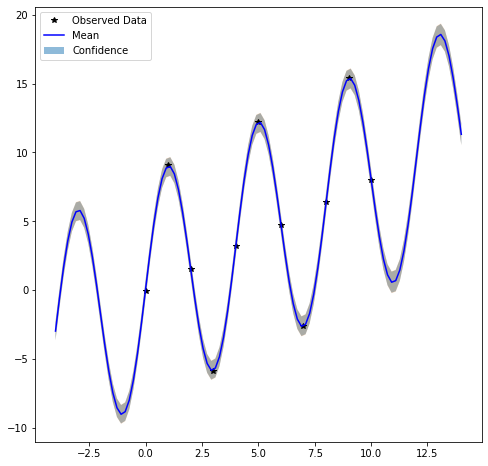

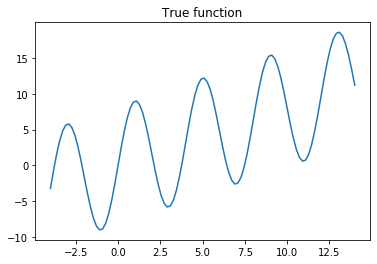

In [25]:
# get training x, y
train_x3 = torch.linspace(0, 10, 11)
#train_x = torch.tensor([random.randint(0, 15) for i in range(10)]).float()
train_y3 = latent_functions.linear_periodic(train_x3, periodicity=0.5)
# testing points:
test_x = create_test_x((train_x3.min().item() - 4, train_x3.max().item()+ 4), 100)
true_y = latent_functions.linear_periodic(test_x, periodicity=0.5, sd = 0.)

posterior, predictive_dist, y_hat, confidence = bayesianGPInference(train_x3, train_y3,
                                                                   core_kernels, kernel_priors, test_x, display_result=True)

# plot true
plt.plot(test_x.numpy(), true_y.numpy())
plt.title("True function")
plt.show()